# ニューラルネットワークによる関数近似

## このファイルについて
ニューラルネットワークをNumpyにより実装し，関数近似を行ってみる．

## ライブラリのimport

In [119]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import random
from tqdm import tqdm

## 近似する関数
* このファイルでは1入力，1出力の関数と，2入力1出力の関数を近似する．
* 近似した関数を視覚化してみて差を定性的に評価したいので，入力値を一定感覚に区切る．2入力1出力関数は入力が格子点になる．
* 1入力1出力関数
    * 線形関数
    * 正規分布
* 2入力1出力
    * 線形関数
    * y = sinx_1 + cosx_2 + const
    * y = (x_1)^2 - x_1 + const

### 1入力1出力
以下の2種類の関数を用意しておく．
* 線形関数
* 非線形関数(正規分布をy方向に平行移動したもの)

In [120]:
# 入力する値
x = np.arange(-10, 10, 0.1)
print(x.shape)

(200,)


In [121]:
# 結果を表示するための関数
def plot_2d(x, t, y=None):
    """
    x: 入力値1次元numpy配列
    t: 近似したい値(教師データ)
    y: モデルの推論結果
    """
    plt.scatter(x, t, label='target', color='red')
    if y is not None:
        plt.scatter(x, y, label='predict')
    
    plt.grid()
    plt.legend()
    plt.show()

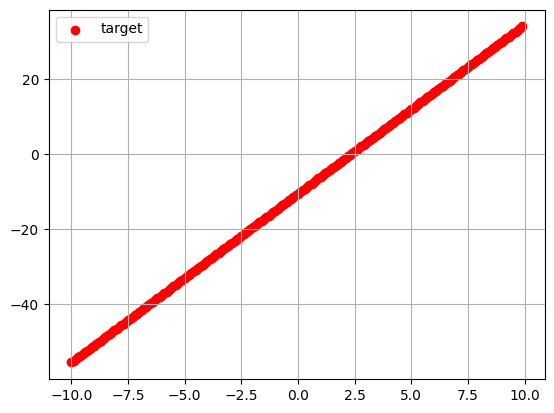

In [122]:
# 1入力1出力の線形関数
def single_linear_func(x:np.ndarray)->np.ndarray:
    """
    x: 1次元のnumpy配列
    return: 1次元のnumpy 配列
    """
    return 4.5*x - 10.5
plot_2d(x, single_linear_func(x))

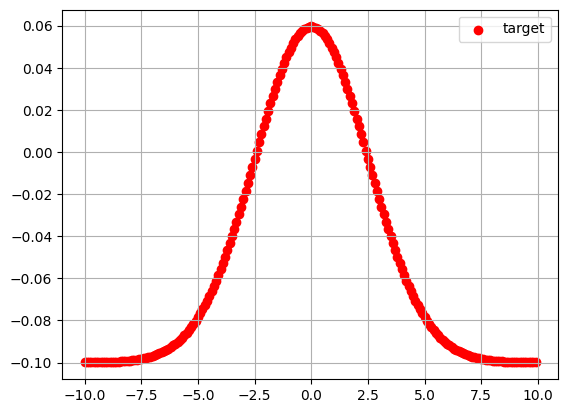

In [123]:
def single_non_linear_func(x:np.ndarray)->np.ndarray:
    """
    1入力1出力の非線形関数
    x: 1次元のnumpy配列
    return: 正規分布を負の値も取るように平行移動させた値
    """
    mean = 0
    sigma = 2.5
    bias = 0.1

    return (1/np.sqrt(2*np.pi*np.square(sigma)))*np.exp(-(x*x-mean)/(2*np.square(sigma))) - bias

plot_2d(x, single_non_linear_func(x))

### 2入力1出力
* 線形関数
* 非線形関数

In [124]:
# 入力する値
x_1 = np.arange(-10,10, 0.1)
x_2 = np.arange(-10,10, 0.1)
X_1, X_2 = np.meshgrid(x_1, x_2)

In [125]:
def plot_3d(X_1, X_2, Y):
    """
    X_1, X_2: 入力となる2次元numpy配列
    Y: X_1, X_2に対応する出力値の2次元numpy配列
    """
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection' : '3d'})
    ax.plot_surface(X_1, X_2, Y, rstride=1, cstride=10, cmap='jet', alpha=0.4)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

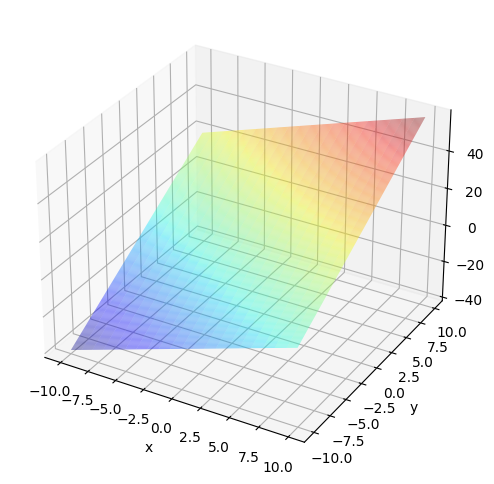

In [126]:
def double_linear_func(x_1:np.ndarray, x_2:np.ndarray)->np.ndarray:
    """
    2入力1出力の線形関数
    x_1, x_2: 入力(2次元配列でも次元数が一致していれば可)
    return: 成分ごとに独立して非線形関数をかました関数
    """
    return 2*x_1 + 3*x_2 + 10

plot_3d(X_1, X_2, double_linear_func(X_1, X_2))

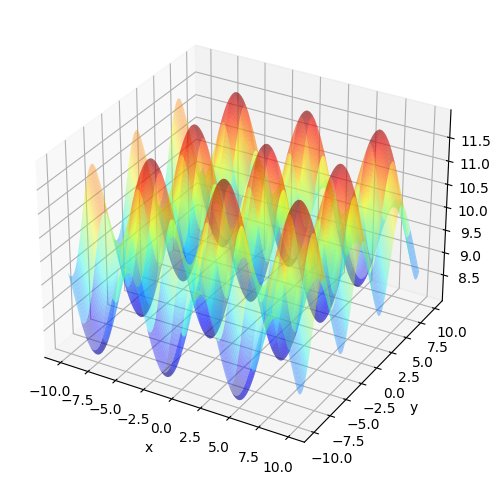

In [127]:
def double_non_linear_func(x_1:np.ndarray, x_2:np.ndarray)->np.ndarray:
    """
    2入力1出力の線形関数
    x_1, x_2: 入力(2次元配列でも次元数が一致していれば可)
    return: 成分ごとに独立して非線形関数をかました関数
    """
    
    return np.sin(x_1) + np.cos(x_2) + 10

plot_3d(X_1, X_2, double_non_linear_func(X_1, X_2))

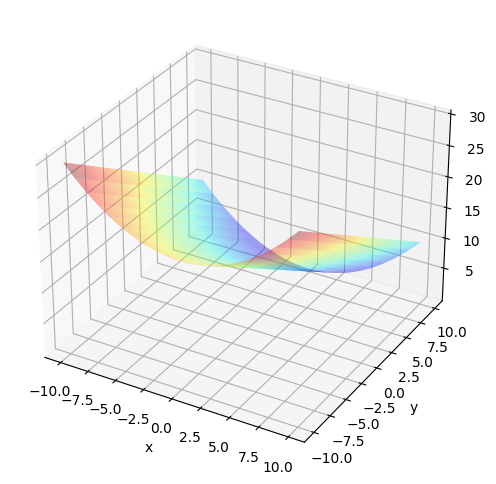

In [128]:
def double_non_linear_func_2(x_1:np.ndarray, x_2:np.ndarray)->np.ndarray:
    """
    2入力1出力の線形関数
    x_1, x_2: 入力(2次元配列でも次元数が一致していれば可)
    return: 成分ごとに独立して非線形関数をかました関数
    """
    
    return 0.1*x_1*x_1 - x_2  + 10

plot_3d(X_1, X_2, double_non_linear_func_2(X_1, X_2))

## ニューラルネットワークの実装
numpyでニューラルネットワークを実装する．層単位でクラスを作成し，それぞれのクラスには以下のメソッドを持たせる．
入力は(バッチ, データの次元)の2次元行列を想定
* forward: 入力値を順伝播する
* backward: 勾配を逆伝播する
* update: learning rateを受け取りパラメータを更新する

In [129]:
class BaseLayer:
    def forward(self):
        raise NotImplementedError("Subclass must implement this method")
    
    def backward(self):
        raise NotImplementedError("Subclass must implement this method")
    
    def update(self):
        raise NotImplementedError("Subclass must implement this method")

In [130]:
class LinearLayer(BaseLayer):
    def __init__(self, hidden_input, hidden_output):
        self.W = random((hidden_input, hidden_output))
        self.B = random(hidden_output)
        self.X = None

        self.dW = None
        self.dB = None

    def __call__(self, X):
        return self.forward(X)

    def forward(self, X):
        self.X = X
        Y = np.dot(self.X, self.W) + self.B
        return Y
    
    def backward(self, dY):
        self.dW = np.dot(self.X.T, dY)
        self.dX = np.dot(dY, self.W.T)
        self.dB = np.sum(dY, axis=0)
        return self.dX
    
    def update(self, lr):
        self.W -= lr*self.dW
        self.B -= lr*self.dB

In [131]:
class MSELayer(BaseLayer):
    def __call__(self, Y, T):
        return self.forward(Y,T)

    def forward(self, Y, T):
        self.Y = Y
        self.T = T
        loss = np.mean(((Y-T)**2)/2)
        return loss
    
    def backward(self):
        batch = self.Y.shape[0]
        d_mse = (self.Y - self.T)/batch
        return d_mse
    
    def update(self, lr):
        pass

In [132]:
class ReLULayer(BaseLayer):
    def __init__(self):
        pass

    def __call__(self, X):
        return self.forward(X)

    def forward(self, X):
        self.X = X
        return np.maximum(self.X, 0)
    
    def backward(self, dY):
        dX = dY*(self.X > 0).astype(np.float64)  # ReLU関数の勾配を計算
        return dX
    
    def update(self, lr):
        pass

In [133]:
class Model:
    def __init__(self, layers:list, loss_layer):
        self.layers = layers
        self.loss_layer = loss_layer

    def __call__(self, X, T):
        return self.forward(X, T)

    def forward(self, X, T):
        # 全ての層に入力を通してlossを返す
        self.X = X
        self.T = T
        for layer in self.layers:
            self.X = layer(self.X)
        loss = self.loss_layer(self.X, self.T)
        return loss
    
    def backward(self):
        reversed_layers = self.layers[::-1]

        dout = self.loss_layer.backward()

        for layer in reversed_layers:
            dout = layer.backward(dout)
        
    def update(self, lr):
        for layer in self.layers:
            layer.update(lr)

    def predict(self, X):
        self.X = X
        for layer in self.layers:
            self.X = layer(self.X)
        return self.X

## 学習に用いるクラス設計
* DataLoader: データセットをミニバッチ単位に分割する
* Trainer: 学習の過程や結果などを出力
* plot_history: 学習過程のlossを出力する

In [134]:
class DataLoader:
    def __init__(self, dataset:tuple, batch_size:int):
        """
        イテレーションごとにミニバッチを出力するdataloader
        中途半端なインデックスのデータは捨てる
        dataset: (入力テンソル, 教師テンソル)のtuple
        入力テンソル: (データ数, データ次元)
        教師テンソル: (データ数, データ次元)
        batch_size: ミニバッチサイズ
        """
        self.batch_size = batch_size
        self.batch_num = int(dataset[0].shape[0]/batch_size)  # mini batch数
        self.cut_input = dataset[0][:self.batch_num*batch_size] 
        self.cut_target = dataset[1][:self.batch_num*batch_size] 

    def __iter__(self):
        self.batch_counter = 0  # 何バッチ目まで出力したかを格納
        return self
    
    def __next__(self):
        if self.batch_counter == self.batch_num:
            raise StopIteration
        start = self.batch_counter*self.batch_size
        end = (self.batch_counter+1)*self.batch_size
        minibatch_input = self.cut_input[start:end]
        minibatch_target = self.cut_target[start:end]
        self.batch_counter += 1
        return minibatch_input, minibatch_target

In [135]:
T = double_non_linear_func(X_1, X_2)
def make_dataset(X_1:np.ndarray, T:np.ndarray, X_2=None)->tuple:
    """
    2つの入力の説明変数numpy配列と1つの目的変数numpy配列を受け取り
    (入力np.array, 教師np.array)を返す
    input
    X_1, X_2: 
    2次元(1次元)numpy配列
    np.meshgrid で作成した2次元配列にも対応できる
    T:
    2次元(1次元)numpy配列
    目的変数
    return
    (入力np.array, 教師np.array)それぞれ2次元np.array
    """
    if X_2 is None:
        # 説明変数が1次元の場合
        X = X_1.reshape(-1,1)
        
    else:
        # 説明変数が2次元の場合
        X = np.array([(i,j) for i,j in zip(X_1.reshape(-1), X_2.reshape(-1))])
        
    dataset = (X, T.reshape(-1,1))
    return dataset
dataset = make_dataset(X_1, T, X_2)

In [136]:
class Trainer:
    def __init__(self, model, dataloader, epochs=1000, lr=0.001):
        self.model = model
        self.dataloader = dataloader
        self.epochs = epochs
        self.lr = lr
        self.history = []  # 学習時の損失を記録するlist

    def train(self):
        for epoch in range(0, self.epochs):
            print(f"----------epoch: {epoch+1} start----------")
            loss = 0
            iter_counter = 0
            for batch in self.dataloader:
                X = batch[0]
                T = batch[1]
                loss += self.model(X, T)
                self.model.backward()
                self.model.update(self.lr)

                iter_counter += 1
            self.history.append(loss/iter_counter)
            print(self.history[-1])
    
    def get_model(self):
        return self.model
    
    def get_history(self)->list:
        return self.history

In [137]:
def plot_history(history):
    plt.plot(history, marker="o")
    plt.xlabel("epoch")
    plt.ylabel("MSE Loss")
    plt.ylim(bottom=0)
    plt.show()

## 実際に近似してみる

### 1入力1出力の近似
1層のNNと2層異常のNNで線形関数と非線形関数をそれぞれ近似してみる．1層NNは，線形関数なので非線形関数をうまく近似できないが，非線形関数は線形関数を近似できると予想．
* 線形関数の線形近似
* 非線形関数の線形近似
* 線形関数の非線形近似
* 非線形関数の非線形近似

#### 線形関数の線形近似

----------epoch: 1 start----------
231.13948782784354
----------epoch: 2 start----------
90.34696779925207
----------epoch: 3 start----------
59.34845471604997
----------epoch: 4 start----------
50.27792553723646
----------epoch: 5 start----------
46.12686285499851
----------epoch: 6 start----------
43.31950311582531
----------epoch: 7 start----------
40.99398561991621
----------epoch: 8 start----------
38.902057705601244
----------epoch: 9 start----------
36.95816042783465
----------epoch: 10 start----------
35.127779377733575
----------epoch: 11 start----------
33.39469093749949
----------epoch: 12 start----------
31.74982635562498
----------epoch: 13 start----------
30.187097964855166
----------epoch: 14 start----------
28.701747676275073
----------epoch: 15 start----------
27.28967361704307
----------epoch: 16 start----------
25.947149347295863
----------epoch: 17 start----------
24.67070328825805
----------epoch: 18 start----------
23.457064137775752
----------epoch: 19 start-----

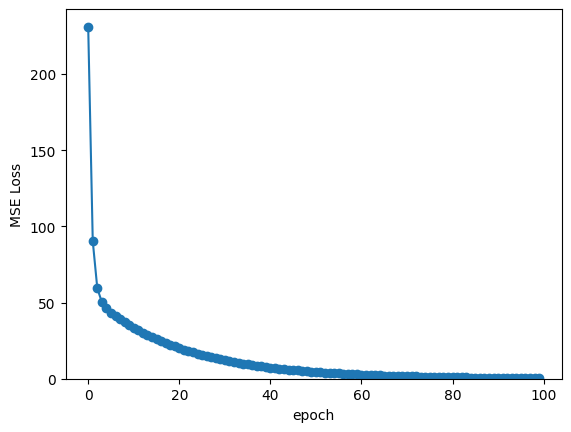

In [138]:
# 線形関数の線形近似
x = np.arange(-10, 10, 0.1)
t = single_linear_func(x)
dataset = make_dataset(x, t)
dataloader = DataLoader(dataset, batch_size=8)
model = Model([
    LinearLayer(1,1),
],
MSELayer())
trainer = Trainer(model, dataloader, epochs=100)
trainer.train()
trained_model = trainer.get_model()
plot_history(trainer.history)

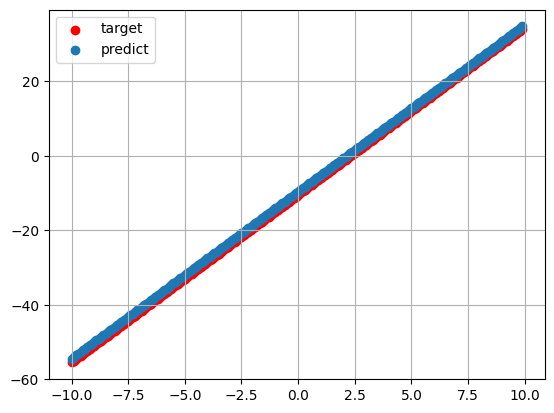

In [139]:
test = trained_model.predict(x.reshape(-1,1))
plot_2d(x, t, trained_model.predict(x.reshape(-1,1)))

#### 非線形関数の線形近似

----------epoch: 1 start----------
7.462881009000064
----------epoch: 2 start----------
1.3733959051309261
----------epoch: 3 start----------
0.32565650040024363
----------epoch: 4 start----------
0.1524491825607743
----------epoch: 5 start----------
0.12440280583715219
----------epoch: 6 start----------
0.11778437731706473
----------epoch: 7 start----------
0.11325723948687788
----------epoch: 8 start----------
0.1085151878088617
----------epoch: 9 start----------
0.10361638069292274
----------epoch: 10 start----------
0.09875977114556347
----------epoch: 11 start----------
0.09405306544174254
----------epoch: 12 start----------
0.08953978105580548
----------epoch: 13 start----------
0.08523243309810517
----------epoch: 14 start----------
0.08113017953156304
----------epoch: 15 start----------
0.07722680649049694
----------epoch: 16 start----------
0.07351414134982134
----------epoch: 17 start----------
0.0699834723809173
----------epoch: 18 start----------
0.06662612629616083
-------

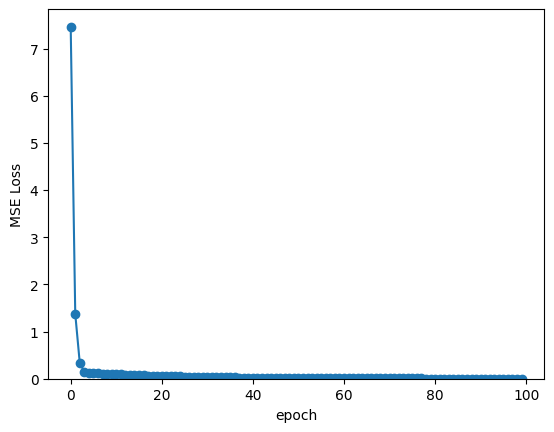

In [140]:
# 非線形関数の線形近似
x = np.arange(-10, 10, 0.1)
t = single_non_linear_func(x)
dataset = make_dataset(x, t)
dataloader = DataLoader(dataset, batch_size=8)
model = Model([
    LinearLayer(1,1),
],
MSELayer())
trainer = Trainer(model, dataloader, epochs=100)
trainer.train()
trained_model = trainer.get_model()
plot_history(trainer.history)

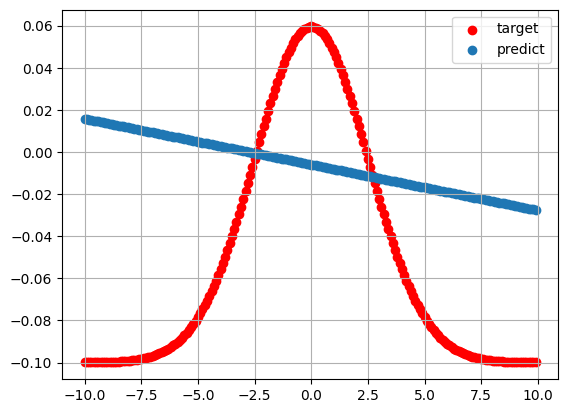

In [141]:
plot_2d(x, t, trained_model.predict(x.reshape(-1,1)))

#### 線形関数の非線形近似

(200,)
(200,)
----------epoch: 1 start----------
328.7819179759236
----------epoch: 2 start----------
319.78282711037104
----------epoch: 3 start----------
311.36535306850686
----------epoch: 4 start----------
303.3800216568035
----------epoch: 5 start----------
295.7439995126356
----------epoch: 6 start----------
288.4086613444086
----------epoch: 7 start----------
281.3489460583545
----------epoch: 8 start----------
274.5429081653337
----------epoch: 9 start----------
267.9750038374155
----------epoch: 10 start----------
261.6339441201028
----------epoch: 11 start----------
255.50495365963516
----------epoch: 12 start----------
249.58178781614225
----------epoch: 13 start----------
243.85396501506418
----------epoch: 14 start----------
238.31353834992024
----------epoch: 15 start----------
232.95459361710087
----------epoch: 16 start----------
227.7698849062494
----------epoch: 17 start----------
222.75189870475452
----------epoch: 18 start----------
217.89446024293392
----------epoc

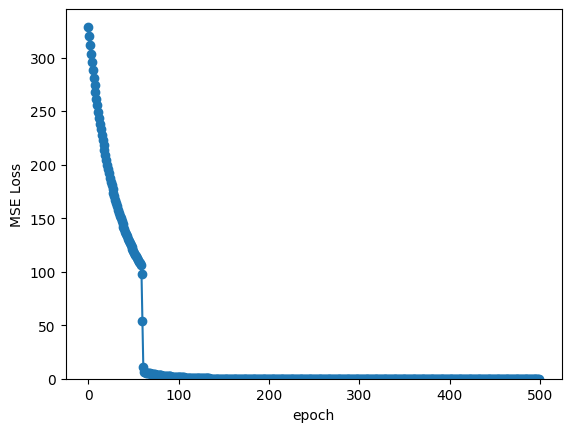

In [142]:
# 線形関数の非線形近似
x = np.arange(-10, 10, 0.1)
t = single_linear_func(x)
print(x.shape)
print(t.shape)
dataset = make_dataset(x, t)
dataloader = DataLoader(dataset, batch_size=8)
model = Model([
    LinearLayer(1,16),
    ReLULayer(),
    LinearLayer(16,1)
],
MSELayer())
trainer = Trainer(model, dataloader, epochs=500)
trainer.train()
trained_model = trainer.get_model()
plot_history(trainer.history)

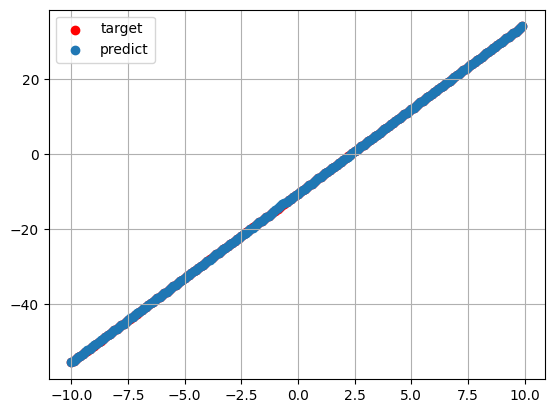

In [143]:
plot_2d(x, t, trained_model.predict(x.reshape(-1,1)))

#### 非線形関数の非線形近似

----------epoch: 1 start----------
3145.69137066881
----------epoch: 2 start----------
387.95361611679505
----------epoch: 3 start----------
103.44406759998544
----------epoch: 4 start----------
31.14743027247027
----------epoch: 5 start----------
9.819063195447292
----------epoch: 6 start----------
3.2758414123225505
----------epoch: 7 start----------
1.243979267934764
----------epoch: 8 start----------
0.6079935541903583
----------epoch: 9 start----------
0.40599422749844394
----------epoch: 10 start----------
0.3395012993402047
----------epoch: 11 start----------
0.31562809387799656
----------epoch: 12 start----------
0.30534523229122273
----------epoch: 13 start----------
0.2995053331288228
----------epoch: 14 start----------
0.2951875959364164
----------epoch: 15 start----------
0.2914370775549383
----------epoch: 16 start----------
0.28792621069062063
----------epoch: 17 start----------
0.2845398977456865
----------epoch: 18 start----------
0.28123408336296757
----------epoch: 19

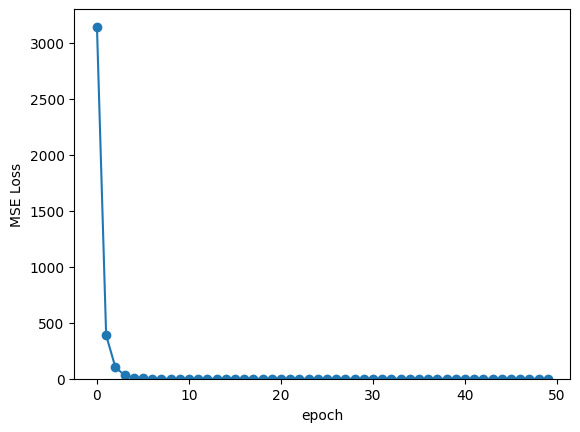

In [144]:
# 非線形関数の非線形近似
x = np.arange(-10, 10, 0.1)
t = single_non_linear_func(x)
dataset = make_dataset(x, t)
dataloader = DataLoader(dataset, batch_size=8)
model = Model([
    LinearLayer(1,16),
    ReLULayer(),
    LinearLayer(16,16),
    ReLULayer(),
    LinearLayer(16,1),
],
MSELayer())
trainer = Trainer(model, dataloader, epochs=50, lr=0.00001)
trainer.train()
trained_model = trainer.get_model()
plot_history(trainer.history)

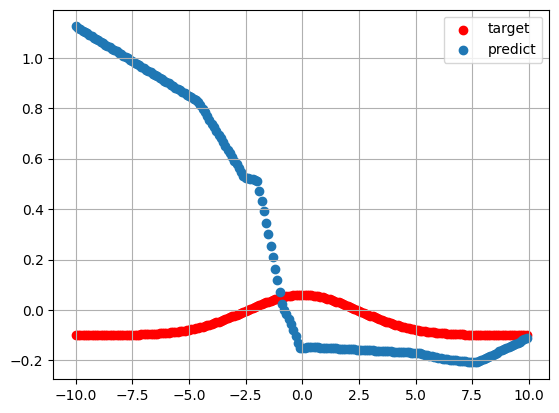

In [145]:
plot_2d(x, t, trained_model.predict(x.reshape(-1,1)))

### 2入力1出力の近似
* 線形関数の線形近似
* 非線形関数の線形近似
* 線形関数の非線形近似
* 非線形関数の非線形近似

#### 線形関数の線形近似

----------epoch: 1 start----------
26.11648503234209
----------epoch: 2 start----------
15.740714586912647
----------epoch: 3 start----------
10.048673257077553
----------epoch: 4 start----------
6.414941141783471
----------epoch: 5 start----------
4.095214243681677
----------epoch: 6 start----------
2.6143310329720433
----------epoch: 7 start----------
1.668954624414517
----------epoch: 8 start----------
1.0654387310653781
----------epoch: 9 start----------
0.6801621044984187
----------epoch: 10 start----------
0.4342065619607616


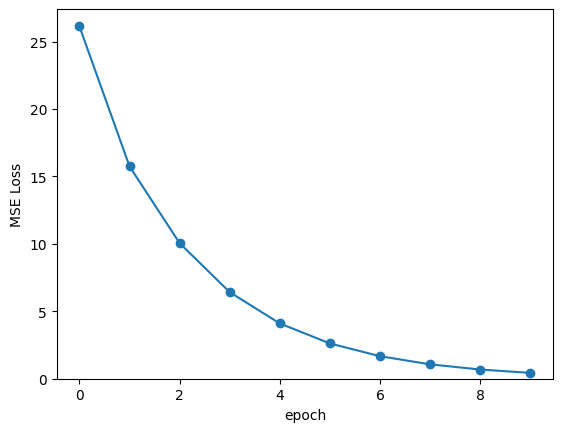

In [146]:
# 線形関数の線形近似
x_1 = np.arange(-10,10, 0.1)
x_2 = np.arange(-10,10, 0.1)
X_1, X_2 = np.meshgrid(x_1, x_2)

T = double_linear_func(X_1, X_2)
dataset = make_dataset(X_1, T, X_2)
dataloader = DataLoader(dataset, batch_size=10)

model = Model([
    LinearLayer(2,1),
],
MSELayer())
trainer = Trainer(model, dataloader, epochs=10, lr=0.0001)
trainer.train()
trained_model = trainer.get_model()
plot_history(trainer.history)

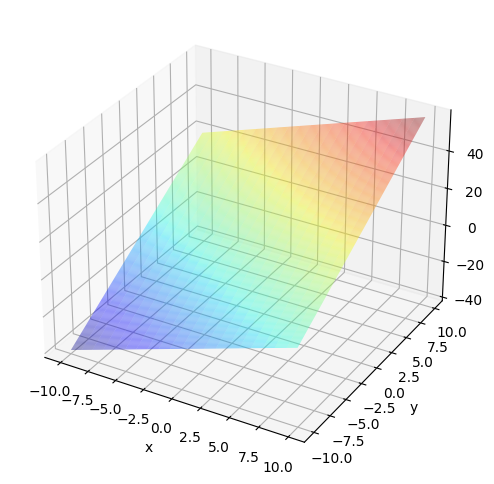

In [147]:
plot_3d(X_1, X_2,T)

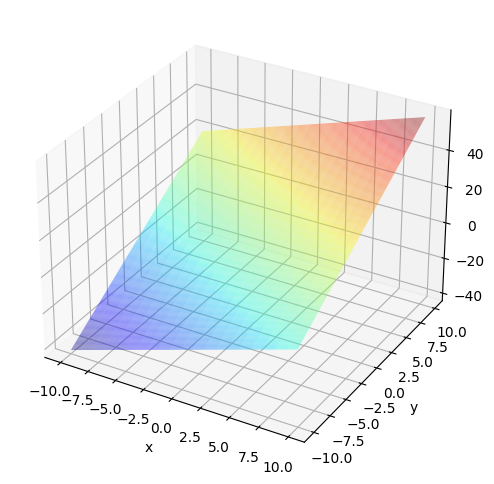

In [148]:
plot_3d(X_1, X_2,trained_model.predict(dataset[0]).reshape(200,200))

#### 非線形関数の線形近似

----------epoch: 1 start----------
21.224465211775758
----------epoch: 2 start----------
13.773625344230524
----------epoch: 3 start----------
8.938969152195272
----------epoch: 4 start----------
5.85373447735257
----------epoch: 5 start----------
3.88507721692341
----------epoch: 6 start----------
2.629044187312589
----------epoch: 7 start----------
1.8277939904382574
----------epoch: 8 start----------
1.3167536346958233
----------epoch: 9 start----------
0.9908855107375509
----------epoch: 10 start----------
0.7831538663760712


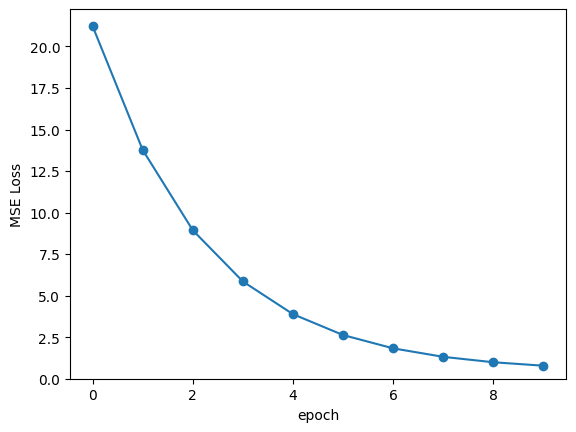

In [149]:
# 非線形関数の線形近似
x_1 = np.arange(-10,10, 0.1)
x_2 = np.arange(-10,10, 0.1)
X_1, X_2 = np.meshgrid(x_1, x_2)

T = double_non_linear_func(X_1, X_2)
dataset = make_dataset(X_1, T, X_2)
dataloader = DataLoader(dataset, batch_size=10)

model = Model([
    LinearLayer(2,1),
],
MSELayer())
trainer = Trainer(model, dataloader, epochs=10, lr=0.0001)
trainer.train()
trained_model = trainer.get_model()
plot_history(trainer.history)

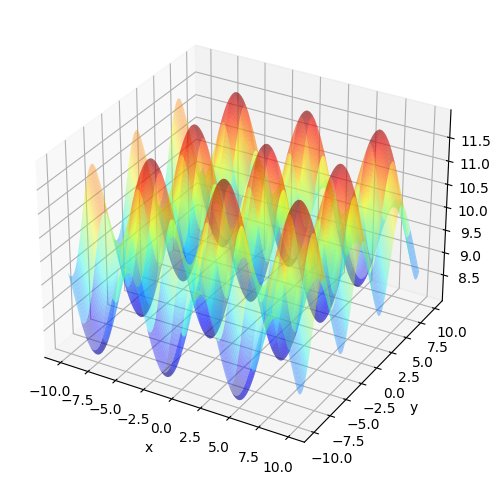

In [150]:
plot_3d(X_1, X_2,T)

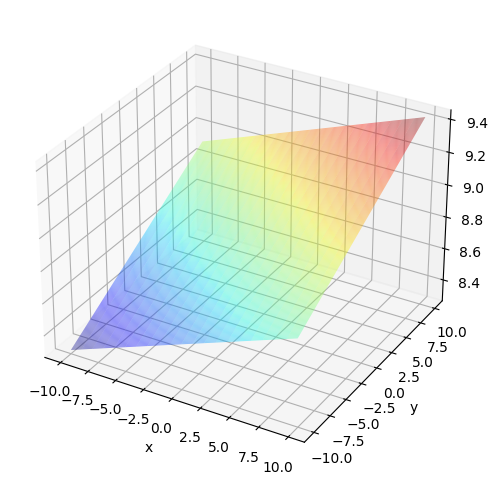

In [151]:
plot_3d(X_1, X_2,trained_model.predict(dataset[0]).reshape(200,200))

----------epoch: 1 start----------
43.57871469349552
----------epoch: 2 start----------
27.941739660537436
----------epoch: 3 start----------
19.461864368130104
----------epoch: 4 start----------
14.04767134743736
----------epoch: 5 start----------
10.590719671232158
----------epoch: 6 start----------
8.383366172416276
----------epoch: 7 start----------
6.973836419770399
----------epoch: 8 start----------
6.073704113813466
----------epoch: 9 start----------
5.498826164619607
----------epoch: 10 start----------
5.131635635483049


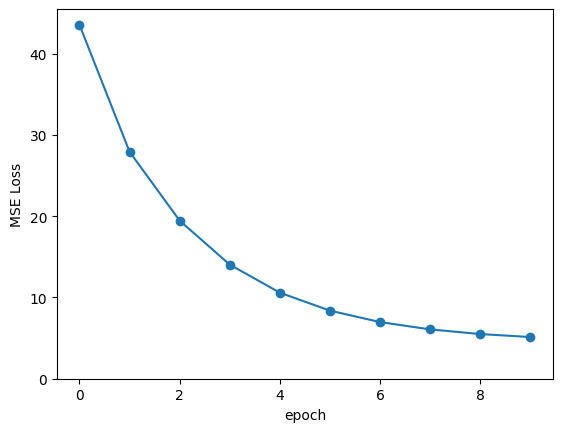

In [152]:
# 非線形関数の線形近似2
x_1 = np.arange(-10,10, 0.1)
x_2 = np.arange(-10,10, 0.1)
X_1, X_2 = np.meshgrid(x_1, x_2)

T = double_non_linear_func_2(X_1, X_2)
dataset = make_dataset(X_1, T, X_2)
dataloader = DataLoader(dataset, batch_size=10)

model = Model([
    LinearLayer(2,1),
],
MSELayer())
trainer = Trainer(model, dataloader, epochs=10, lr=0.0001)
trainer.train()
trained_model = trainer.get_model()
plot_history(trainer.history)

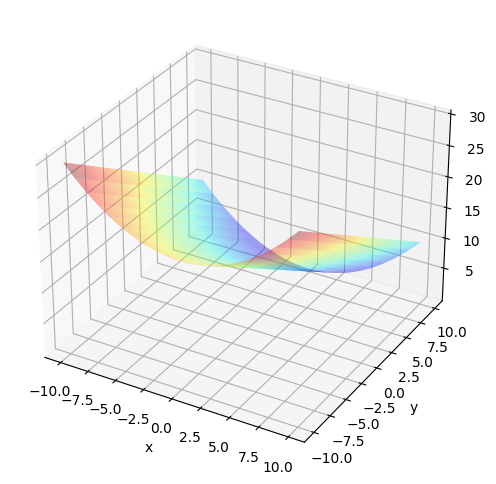

In [153]:
plot_3d(X_1, X_2,T)

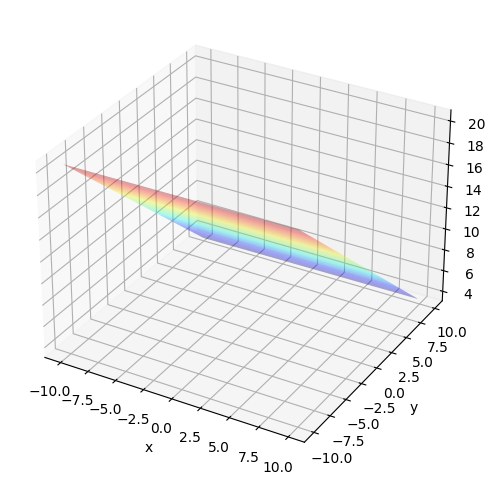

In [154]:
plot_3d(X_1, X_2,trained_model.predict(dataset[0]).reshape(200,200))

#### 線形関数の非線形近似

----------epoch: 1 start----------
45.82348750977351
----------epoch: 2 start----------
4.79732490455029
----------epoch: 3 start----------
1.3510914132873082
----------epoch: 4 start----------
0.9102481197028234
----------epoch: 5 start----------
0.5710651184024794
----------epoch: 6 start----------
0.37116120828315957
----------epoch: 7 start----------
0.25143025487543147
----------epoch: 8 start----------
0.1863034353509734
----------epoch: 9 start----------
0.14297368389857656
----------epoch: 10 start----------
0.11213630814161557


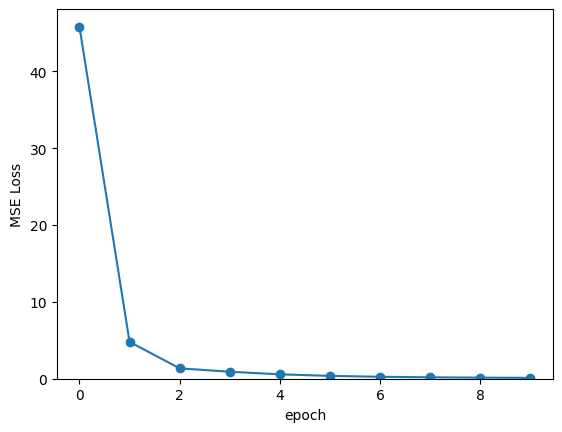

In [155]:
# 線形関数の非線形近似
x_1 = np.arange(-10,10, 0.1)
x_2 = np.arange(-10,10, 0.1)
X_1, X_2 = np.meshgrid(x_1, x_2)

T = double_linear_func(X_1, X_2)
dataset = make_dataset(X_1, T, X_2)
dataloader = DataLoader(dataset, batch_size=10)

model = Model([
    LinearLayer(2,16),
    ReLULayer(),
    LinearLayer(16,1),
],
MSELayer())
trainer = Trainer(model, dataloader, epochs=10, lr=0.0001)
trainer.train()
trained_model = trainer.get_model()
plot_history(trainer.history)

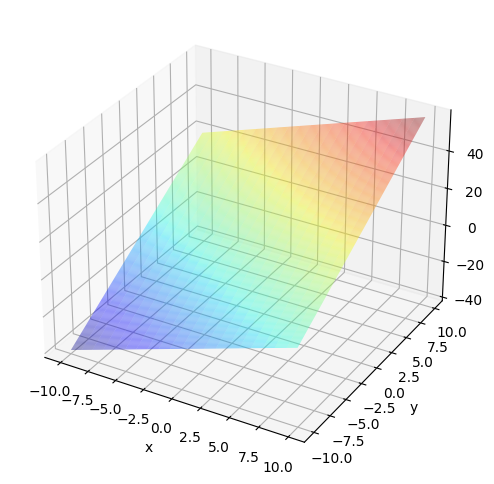

In [156]:
plot_3d(X_1, X_2,T)

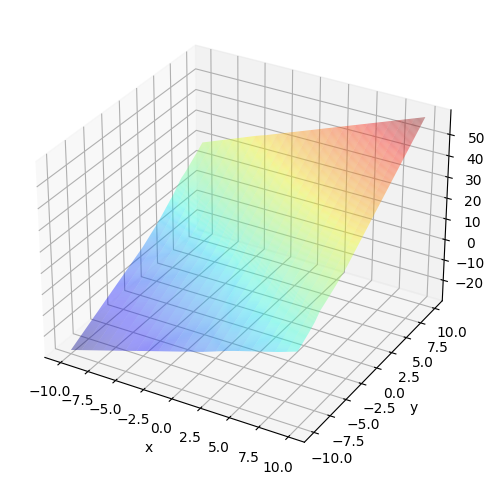

In [157]:
plot_3d(X_1, X_2,trained_model.predict(dataset[0]).reshape(200,200))

#### 非線形関数の非線形近似

----------epoch: 1 start----------
3.835190345347053
----------epoch: 2 start----------
0.7226781950730243
----------epoch: 3 start----------
0.9713408070306795
----------epoch: 4 start----------
0.45230680628856473
----------epoch: 5 start----------
0.3144688876309888
----------epoch: 6 start----------
0.28586020664237033
----------epoch: 7 start----------
0.26429328524752416
----------epoch: 8 start----------
0.24466658684906892
----------epoch: 9 start----------
0.2345395325246169
----------epoch: 10 start----------
0.2288029612948541
----------epoch: 11 start----------
0.2278856955491656
----------epoch: 12 start----------
0.2281856094751697
----------epoch: 13 start----------
0.22732841025328027
----------epoch: 14 start----------
0.22600744739813283
----------epoch: 15 start----------
0.22425212852892534
----------epoch: 16 start----------
0.21957816327747404
----------epoch: 17 start----------
0.21917905372451443
----------epoch: 18 start----------
0.21716735759113026
----------

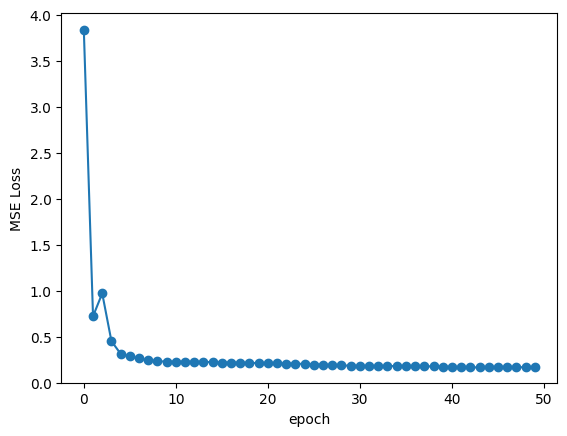

In [158]:
# 非線形関数の非線形近似
x_1 = np.arange(-10,10, 0.1)
x_2 = np.arange(-10,10, 0.1)
X_1, X_2 = np.meshgrid(x_1, x_2)

T = double_non_linear_func(X_1, X_2)
dataset = make_dataset(X_1, T, X_2)
dataloader = DataLoader(dataset, batch_size=10)

model = Model([
    LinearLayer(2,64),
    ReLULayer(),
    LinearLayer(64,1),
],
MSELayer())
trainer = Trainer(model, dataloader, epochs=50, lr=0.001)
trainer.train()
trained_model = trainer.get_model()
plot_history(trainer.history)

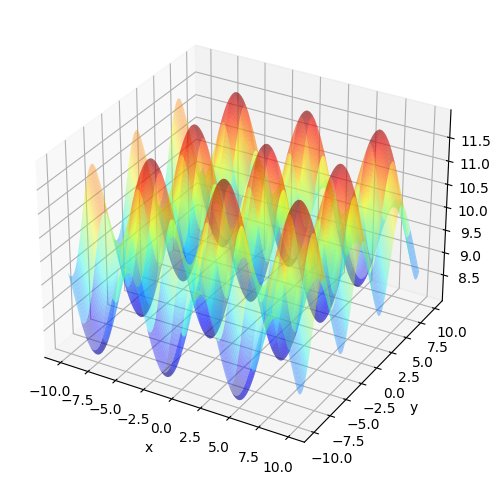

In [159]:
plot_3d(X_1, X_2,T)

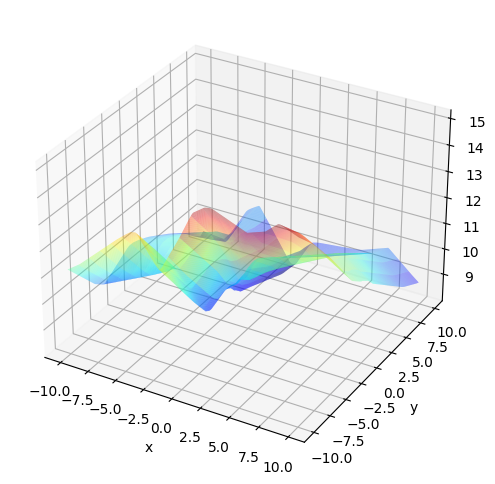

In [160]:
plot_3d(X_1, X_2,trained_model.predict(dataset[0]).reshape(200,200))

----------epoch: 1 start----------
4.686334798539057
----------epoch: 2 start----------
0.5773398082224105
----------epoch: 3 start----------
0.1679433712704072
----------epoch: 4 start----------
0.08568317072959565
----------epoch: 5 start----------
0.07218180825562207
----------epoch: 6 start----------
0.06343374918645128
----------epoch: 7 start----------
0.059254521041202476
----------epoch: 8 start----------
0.07793276425975139
----------epoch: 9 start----------
0.07471355363469791
----------epoch: 10 start----------
0.06651571564454
----------epoch: 11 start----------
0.059738490162217876
----------epoch: 12 start----------
0.055370533443421764
----------epoch: 13 start----------
0.045590536355624725
----------epoch: 14 start----------
0.04331091656687126
----------epoch: 15 start----------
0.045121227664178816
----------epoch: 16 start----------
0.03655087191936303
----------epoch: 17 start----------
0.0363552422219435
----------epoch: 18 start----------
0.03992967653622305
----

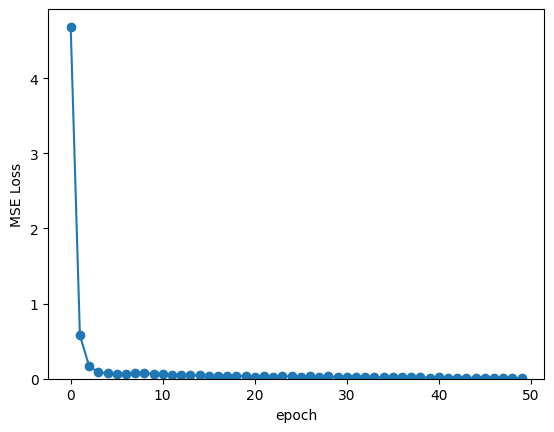

In [161]:
# 非線形関数の非線形近似
x_1 = np.arange(-10,10, 0.1)
x_2 = np.arange(-10,10, 0.1)
X_1, X_2 = np.meshgrid(x_1, x_2)

T = double_non_linear_func_2(X_1, X_2)
dataset = make_dataset(X_1, T, X_2)
dataloader = DataLoader(dataset, batch_size=10)

model = Model([
    LinearLayer(2,64),
    ReLULayer(),
    LinearLayer(64,1),
],
MSELayer())
trainer = Trainer(model, dataloader, epochs=50, lr=0.001)
trainer.train()
trained_model = trainer.get_model()
plot_history(trainer.history)

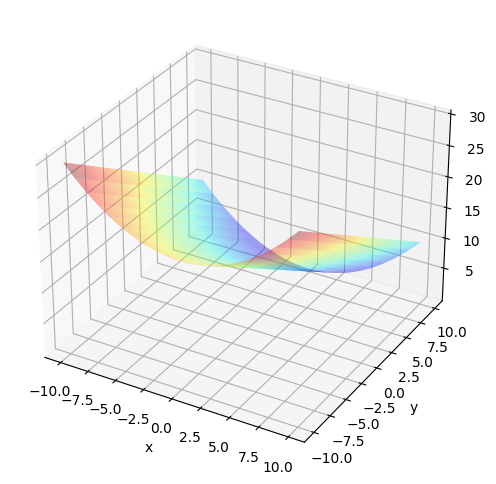

In [162]:
plot_3d(X_1, X_2,T)

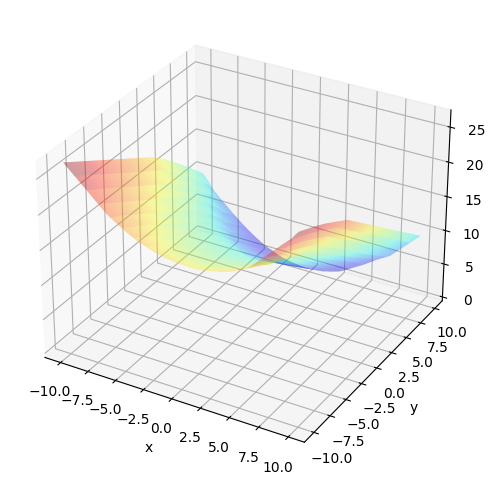

In [163]:
plot_3d(X_1, X_2,trained_model.predict(dataset[0]).reshape(200,200))

## 結果・結論
* 1入力1出力
    * 線形関数の1層NNによる近似  
        関数の形をNN で再現できた．
    * 非線形関数の1層NNによる近似  
        1層NNでは線形関数しか再現できないことを視覚的に確認できた．
    * 線形関数の2層以上NNによる近似  
    2層以上NNで線形関数を近似できることが確認できた．
    * 非線形関数の2層以上NNによる近似  
        * 2層以上NNであってもlearning rateをうまく調整しないと近似がうまくいかないことがわかった．  
        * 学習可能パラメータの数を増やしすぎて学習がうまくいかないことがあった．
        * epoch数が少ないと収束仕切らないことがあった．
        * 適切なハイパーパラメータを選ぶことが重要であることがわかった．

* 2入力1出力
    * 線形関数の1層NNによる近似  
        関数の形をNN で再現できた．
    * 非線形関数の1層NNによる近似  
        1層NNでは線形関数しか再現できないことを視覚的に確認できた．
    * 線形関数の2層以上NNによる近似  
    2層以上NNで線形関数を近似できることが確認できた．
    * 非線形関数の2層以上NNによる近似  
        * 2層以上NNであってもlearning rateをうまく調整しないと近似がうまくいかないことがわかった．  
        * 学習可能パラメータの数を増やしすぎて学習がうまくいかないことがあった．
        * epoch数が少ないと収束仕切らないことがあった．
        * 適切なハイパーパラメータを選ぶことが重要であることがわかった．
        * y = sin(x_1) + cos(x_2) + const の関数は近似が難しいかった．
        * y = (x_1)^2 + x_2 + const の関数は近似が簡単だった．
        * 関数の形状によって近似の難しさが大きく変わることがわかった．